In [1]:
from satpy import Scene
from glob import glob
import proplot as pplt
import pandas as pd
import xarray as xr
import numpy as np

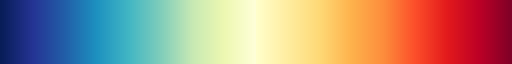

In [2]:
cmap = pplt.Colormap('YlGnBu_r', 'YlOrRd', ratios=(1, 1), name='tropomi_no2')
cmap

In [3]:
filename = glob('../data/clean_lightning/S5P_PAL__L2__NO2____20210729T*_19656_*')[0]

ds_tropomi = xr.open_dataset(filename, group='S5P').isel(time=0)\
                [['nitrogendioxide_tropospheric_column', 'cloud_radiance_fraction_nitrogendioxide_window', 'cloud_pressure_crb',
                'assembled_lon_bounds', 'assembled_lat_bounds', 'time_utc']]

ds_lightning = xr.open_dataset(filename, group='Lightning')

In [4]:
lat_mean = ds_tropomi['nitrogendioxide_tropospheric_column'].latitude.mean('x')
t_overpass = ds_tropomi['time_utc'].where((lat_mean >= 73)&(lat_mean <= 78), drop=True)
t_overpass = pd.to_datetime(t_overpass.to_pandas(), format='%Y-%m-%dT%H:%M:%S.%fZ').mean()

In [5]:
df = pd.read_csv('../data/gld360/density/202107/20210729.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])#, utc=True)
df['delta'] = df['timestamp'] - t_overpass
df = df.set_index('timestamp')

In [6]:
lightning = df[(df['longitude']>120)&(df['longitude']<160)&(df['latitude']>70)&(df['latitude']<85)]['2021-07-29 00:00': t_overpass.strftime('%Y-%m-%d %H:%M')]

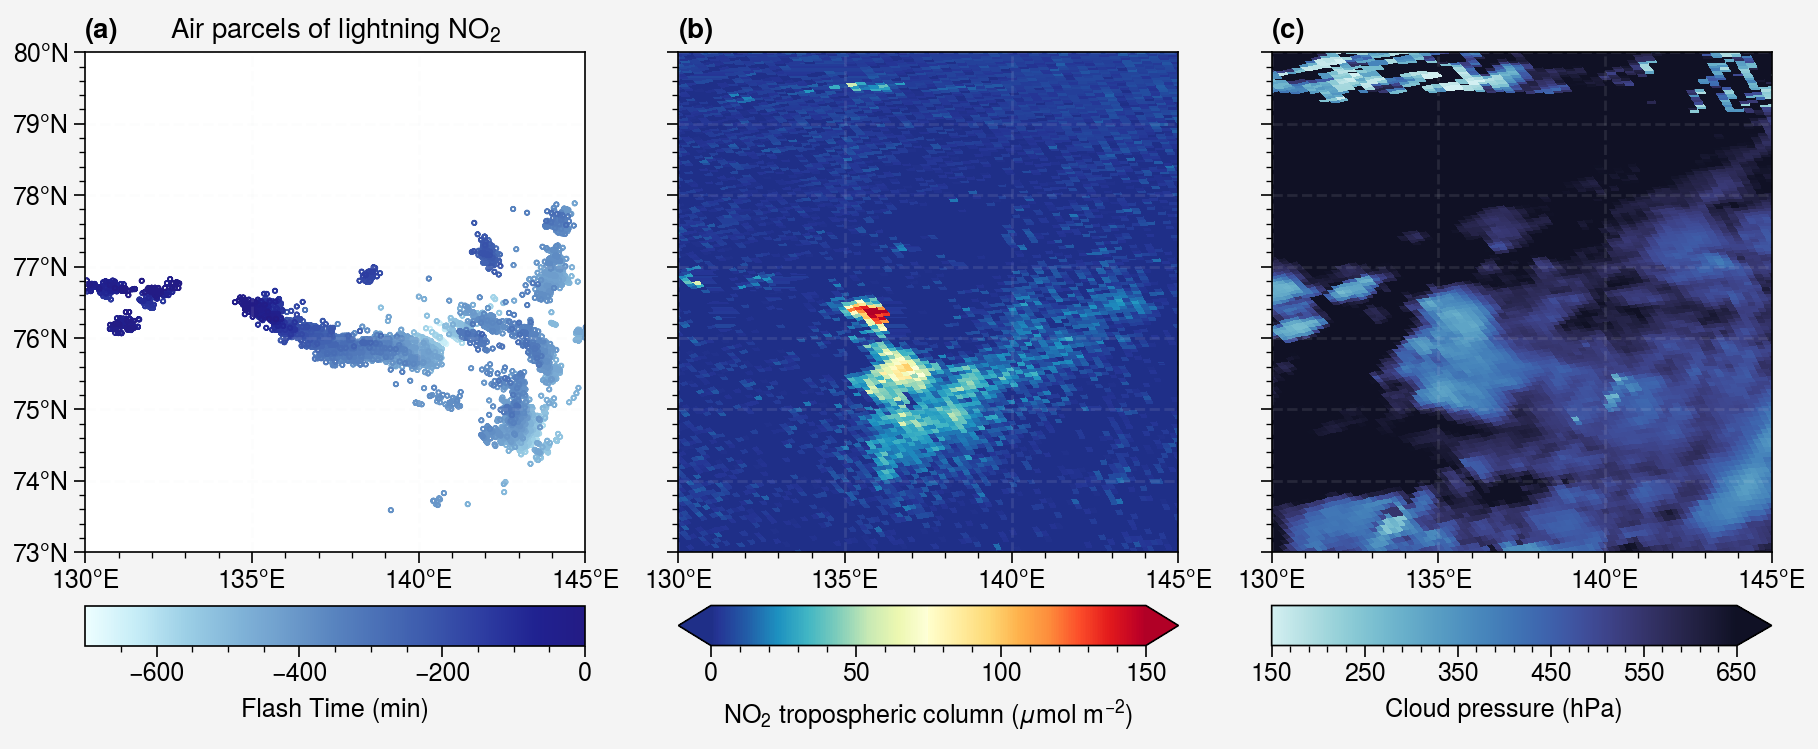

In [7]:
fig, axs = pplt.subplots(ncols=3, span=False, sharey=3, sharex=3)


ax = axs[0]
s = ax.scatter(ds_lightning['longitude_pred'].sel(level=500), ds_lightning['latitude_pred'].sel(level=500),
               marker="$\u25EF$", cmap='Blues2',
               c=ds_lightning['delta'], s=3, vmin=-700, vmax=0)
ax.colorbar(s, loc='b', label=f'Flash Time (min)')

ax = axs[1]
m = ax.pcolormesh(ds_tropomi['assembled_lon_bounds'], ds_tropomi['assembled_lat_bounds'], ds_tropomi['nitrogendioxide_tropospheric_column']*1e6,
              cmap=cmap, discrete=False,cmap_kw={'left': 0.05, 'right': 0.95}, extend='both',
              vmin=0, vmax=150, rasterized=True)
ax.colorbar([m], loc='b', label='NO$_2$ tropospheric column ($\mu$mol m$^{-2}$)')


ax = axs[2]
m = ax.pcolormesh(ds_tropomi['assembled_lon_bounds'], ds_tropomi['assembled_lat_bounds'], ds_tropomi['cloud_pressure_crb']/1e2,
              cmap='Ice_r', discrete=False,cmap_kw={'left': 0.05, 'right': 0.95}, extend='max',
            vmin=150, vmax=650, rasterized=True)
ax.colorbar([m], loc='b', label='Cloud pressure (hPa)', ticks=np.arange(150, 750, 100))

axs.format(abc='(a)', xlim=(130, 145), ylim=(73, 80), gridcolor='gray2', gridlinewidth=1, gridlinestyle='--',
           xlabel='', ylabel='', xformatter='deglon', yformatter='deglat', xticks=5,
           title=['Air parcels of lightning NO$_2$', '', ''])

fig.savefig('../figures/large_lno2.pdf')

In [8]:
print('largest no2 vcd: ', ds_tropomi['nitrogendioxide_tropospheric_column'].max())
print(ds_tropomi['nitrogendioxide_tropospheric_column'].max().values*ds_tropomi['nitrogendioxide_tropospheric_column'].attrs['multiplication_factor_to_convert_to_molecules_percm2'] / 1.41e16 -1,
'times higher than U.S. Los Angeles')


largest no2 vcd:  <xarray.DataArray 'nitrogendioxide_tropospheric_column' ()>
array(0.00078366, dtype=float32)
Coordinates:
    time     datetime64[ns] 2021-07-29
2.347035420758568 times higher than U.S. Los Angeles


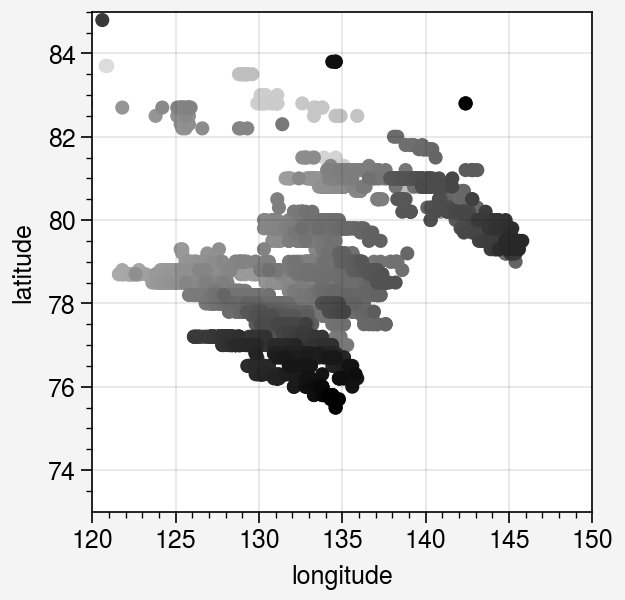

In [9]:
fig, axs = pplt.subplots()
df.plot.scatter(ax=axs, x='longitude', y='latitude', c='delta')
axs.format(xlim=(120, 150), ylim=(73, 85))